Business Problem: 
It is up to you to define a stakeholder and business problem appropriate to this dataset.

If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.

Idea: Start by determining which factors matter. Run tests with ~95% confidence intervals, reject null hypotheses when it is appropriate to do so.

Rubric:
https://github.com/learn-co-curriculum/dsc-mod-2-project-v2-1/blob/master/mod2_project_rubric.pdf

Instructions:
https://docs.google.com/document/d/1N7h3-653wXl0BRC59MIMuURyDFX-DVw0uba6P6N7dzw/edit#
https://github.com/learn-co-curriculum/dsc-project-submissions-online

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import json
import requests
import time
from bs4 import BeautifulSoup
import re
from numpy.random import normal
import warnings
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [2]:
df_data=pd.read_csv('kc_house_data.csv')

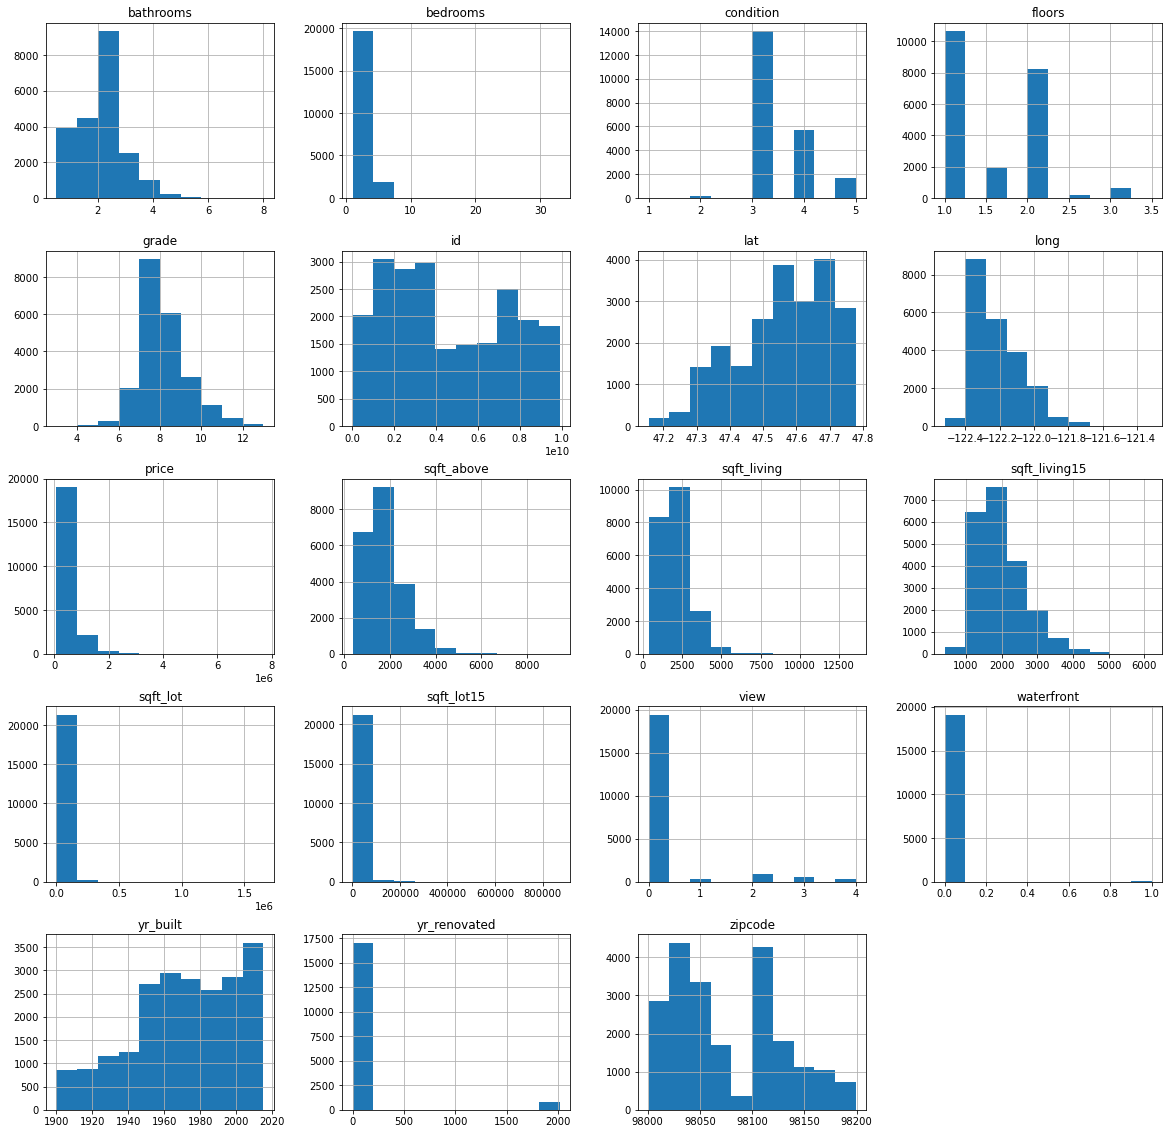

In [3]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df_data.hist(ax = ax);

First, let's see if we can make any conclusions from the Condition variable, which is one of the categorical ones.

In [4]:
df_data.sort_values(['price','sqft_living'], ascending=[False, False]).head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,...,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800
3910,9808700762,6/11/2014,7060000.0,5,4.5,10040,37325,2.0,1.0,2.0,...,11,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449


In [5]:
df_data.condition.min()

1

In [6]:
df_data.condition.max()

5

In [7]:
df_data.condition.mean()

3.4098254387183404

In [8]:
print(df_data['condition'].describe())

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64


In [9]:
print(df_data['condition'].nunique())

5


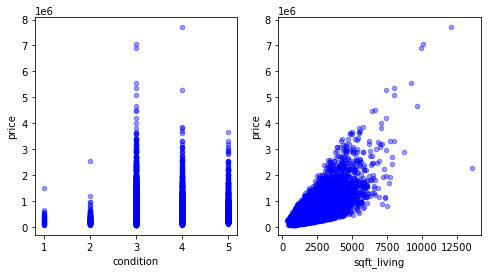

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['condition','sqft_living'], axes):
    df_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

We can see that homes are given a rating of 1-5 depending on how good their condition is. 5 is the best condition, while 1 is the worst. The average home has a rating of 3.41. Do the houses' conditions from our dataset make a difference when determining their final value? Let's observe this further by isolating the houses with condition ratings of 5. 

In [11]:
df_data_good_condition = df_data.loc[df_data.condition == 5]
df_data_good_condition.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3,2487200875,12/9/2014,604000.0,4,3.0,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
25,1202000200,11/3/2014,233000.0,3,2.0,1710,4697,1.5,0.0,0.0,...,6,1710,0.0,1941,0.0,98002,47.3048,-122.218,1030,4705


In [12]:
df_data.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [13]:
df_data_good_condition.price.describe()
#It is helpful to note that sample size of homes with good condition is 1,701.

count    1.701000e+03
mean     6.125777e+05
std      4.113179e+05
min      1.100000e+05
25%      3.500000e+05
50%      5.260000e+05
75%      7.250000e+05
max      3.650000e+06
Name: price, dtype: float64

In [14]:
df_data.sqft_living.mean()

2080.3218502569803

In [15]:
df_data_good_condition.sqft_living.mean()

2022.9112286890065

We can see that on average, the homes with condition scores of 5 are more valuable. But, is that difference statistically significant? We now have the information to make that determination.

In [16]:
#Good (5) condition mean (price): $612,578
#Population mean (price): $540,297
#Population standard deviation: $367,368
#Sample size: 1,701

In [17]:
numerator_condition=612578-540297
numerator_condition

72281

In [18]:
denominator_condition=367368/(1701)**.5
denominator_condition

8907.363322246227

In [19]:
z_score_condition=numerator_condition/denominator_condition
z_score_condition

8.114747022778053

##### Despite the fact that on average, houses with condition ratings of 5 or higher have slightly less square feet, we can conclude with 95% confidence that they are more valuable. Our z-score is 8.11, which is far more than we needed to make this conclusion. It is worth noting that we arrived at this z-score without removing outliers. Outliers tend to increase the standard deviation, meaning they make it less likely that we would reject a null hypothesis. As a result, condition is a variable we will want to include in our model. Let's investigate the number of floors using a similar process.

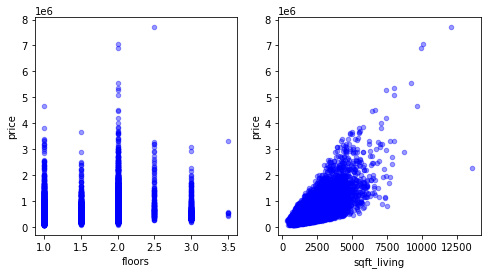

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['floors','sqft_living'], axes):
    df_data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

1.5 is very close to the middle of the pack in terms of number of floors. It is a bit hard to tell from our scatter plot, but it looks like there are more valuable homes with 2 floors, even though there are less of them. Let's see a quick correlation matrix consisting of our dependent variable (price), floors, and sqft_living (which we're already nearly certain has a positive impact on price).

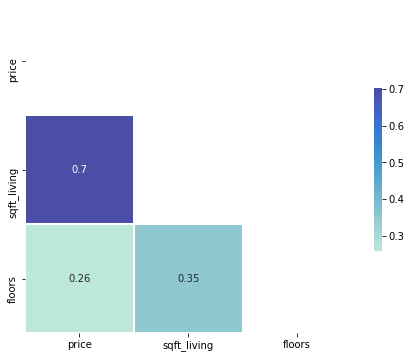

In [21]:
corr = df_data[['price','sqft_living','floors']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

This matrix leads us to believe that more floors generally means more value. (Also, as expected, the amount of square feet has a strong positive correlation with price.) Let's see if this difference is statistically significant.

In [22]:
df_data.sort_values(['price','floors'], ascending=[False, False]).head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,...,13,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800
3910,9808700762,6/11/2014,7060000.0,5,4.5,10040,37325,2.0,1.0,2.0,...,11,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449


In [23]:
df_data.floors.min()

1.0

In [24]:
df_data.floors.max()

3.5

In [25]:
df_data.floors.mean()

1.4940964022780943

In [26]:
df_data.floors.median()

1.5

In [27]:
df_data.floors.describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [28]:
#Creating a dataframe consisting of all homes with 2 or more floors.
df_data_2_floors = df_data.loc[df_data.floors >= 2]

In [29]:
df_data_2_floors.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,9.014000e+03,9.014000e+03,9014.000000,9014.000000,9014.000000,9.014000e+03,9014.000000,8047.000000,8988.000000,9014.000000,9014.000000,9014.000000,9014.000000,7454.000000,9014.000000,9014.000000,9014.000000,9014.000000,9014.000000
mean,4.661544e+09,6.522873e+05,3.594520,2.618926,2528.556690,1.535844e+04,2.077879,0.009569,0.254450,3.182938,8.356778,2359.651653,1991.151542,81.979340,98068.895607,47.558777,-122.176562,2281.322720,12940.896716
std,2.921332e+09,4.441065e+05,0.861994,0.630352,990.224943,4.426575e+04,0.260650,0.097357,0.807296,0.466013,1.143465,876.972931,24.559948,396.254237,46.559114,0.133722,0.147888,752.857321,30514.606033
min,1.000102e+06,9.000000e+04,1.000000,0.500000,550.000000,5.720000e+02,2.000000,0.000000,0.000000,1.000000,5.000000,550.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.133010e+09,3.800000e+05,3.000000,2.500000,1810.000000,4.066000e+03,2.000000,0.000000,0.000000,3.000000,8.000000,1730.000000,1987.000000,0.000000,98032.000000,47.479325,-122.304000,1690.000000,4314.000000
50%,3.905100e+09,5.400000e+05,4.000000,2.500000,2390.000000,6.633500e+03,2.000000,0.000000,0.000000,3.000000,8.000000,2260.000000,1999.000000,0.000000,98058.000000,47.574700,-122.182000,2190.000000,6600.000000
75%,7.504101e+09,7.700000e+05,4.000000,2.750000,3060.000000,1.030450e+04,2.000000,0.000000,0.000000,3.000000,9.000000,2860.000000,2006.000000,0.000000,98107.000000,47.667500,-122.056000,2750.000000,9920.000000
max,9.839301e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.024068e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.359000,6210.000000,871200.000000


In [30]:
len(df_data_2_floors)

9014

In [31]:
df_data_2_floors.price.mean()

652287.3035278455

In [32]:
df_data.price.mean()

540296.5735055795

In [33]:
#2+ floors mean (price): $652,287
#Population mean (price): $540,297
#Population standard deviation: $367,368
#Sample size: 9,014

In [34]:
numerator_floors=652287-540297
denominator_floors=367368/(9014)**.5

In [35]:
z_score_floors=numerator_floors/denominator_floors

In [36]:
z_score_floors

28.94254369350173

It certainly seems as though the number of floors should be included in our final model, as they are statistically significant.

Now, before we do any transformations that relate to the distribution of data, let's make sure that our data is sufficient. Our data should be formatted so that it can be fed into a model.

In [37]:
df_data.price.isna().sum()

0

In [38]:
df_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [39]:
#yr_renovated: Change NaN to 0.
#waterfront: Change NaN to 0.
#view: Change NaN to 0.

In [40]:
df_data['yr_renovated'] = df_data['yr_renovated'].fillna(0)
df_data['waterfront'] = df_data['waterfront'].fillna(0)
df_data['view'] = df_data['view'].fillna(0)

In [41]:
df_data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [42]:
df_data.shape

(21597, 21)

In [43]:
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

All columns are in numerical format (integers or floats) except for date and sqft_basement, which may be unnecessary because of the other metrics that relate to square feet. Regardless, we do not know enough yet to conclude that it will not be helpful in our model, so we will want to clean it up.

In [44]:
df_data['sqft_basement']=df_data['sqft_basement'].replace('?',0)

In [45]:
df_data['sqft_basement'] = df_data['sqft_basement'].astype(float)

In [46]:
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [47]:
df_data.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


In [48]:
pd.to_datetime(df_data['date'])

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 21597, dtype: datetime64[ns]

In [49]:
df_data['date']=pd.to_datetime(df_data['date'])

In [50]:
df_data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [51]:
#Note: .summary() and .pvalues can be very helpful. What can we do so that those functions work with our dataset?
#Note: Use R^2 and describe its formal definition.
#Note: Try to alter variables that are not statistically significant so that we can make them significant
#and include them. If we can't alter them so that they are statistically significant, remove them. We do not
#want those in our final model.
#Idea: two-sample t-test, comparing waterfront vs. no waterfront. If it turns out that waterfront
#makes sa significant difference, that could be a good reason to include in the linear regression.

##Train-test split

Time to check for multicollinearity. If the independent variables in our model have high correlations with each other, that can lead to issues.

In [52]:
abs(df_data.corr())>0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [53]:
df = df_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['Pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['Pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['Correlation']
df.drop_duplicates(inplace=True)
df[(df.Correlation>.75) & (df.Correlation<1)]

,Correlation
Pairs,
"(sqft_above, sqft_living)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(sqft_living, bathrooms)",0.755758


We will need to decide which variables to remove from our model. Sqft_above, sqft_living15, and bathrooms could probably be removed from our model, as these both have a very high correlation with sqft_living. This small dataframe gives us some help. Let's run a regression and see where things stand as it is.

In [54]:
outcome='price'
x_cols=[col for col in df_data.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df_data).fit()
model.summary()
#Investigate: Is being in a particular school district beneficial for price?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     132.0
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:16   Log-Likelihood:            -2.9411e+05
No. Observations:               21597   AIC:                         5.890e+05
Df Residuals:                   21207   BIC:                         5.921e+05
Df Model:                         389                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  6.86e+06   2.94e+06      2.333      0.020     1.1e+06    1.26e+07
date[T.Timestamp('2014-05-03 00:00:00')]  1.756e+05   1.03e+05      1.702      0.089   -2.66e+04    3.78e+05
date[T.Timestamp('2014-05-04 00:00:00')] -6.548e+04   9.29e+04     -0.705      0.481   -2.48e+05    1.17e+05
date[T.Timestamp('2014-05-05 00:00:00')]  1.645e+04   3.28e+04      0.501      0.616   -4.79e+04    8.08e+04
date[T.Timestamp('2014-05-06 00:00:00')]  -149.1239   3.29e+04     -0.005      0.996   -6.47e+04    6.44e+04
date[T.Timestamp('2014-05-07 00:00:00')]  1.448e+04   3.21e+04      0.451      0.652   -4.85e+04    7.74e+04
date[T.Timestamp('2014-05-08 00:00:00')]  4.844e+04   3.31e+04      1.463      0.143   -1.65e+04    1.13e+05
date[T.Timestamp('2014-05-09 00:00:00')] -1.478e+04   3.31e+04     -0.447      0.655   -7.97e+04    5.01e+04
date[T.Timestamp('2014-05-10 00:00:00')]  3.117e+04    9.3e+04      0.335      0.737   -1.51e+05    2.13e+05
date[T.Timestamp('2014-05-11 00:00:00')]  6.345e+04   1.44e+05      0.441      0.659   -2.19e+05    3.45e+05
date[T.Timestamp('2014-05-12 00:00:00')]  2.123e+04   3.32e+04      0.639      0.523   -4.39e+04    8.63e+04
date[T.Timestamp('2014-05-13 00:00:00')]   4.62e+04   3.27e+04      1.414      0.157   -1.78e+04     1.1e+05
date[T.Timestamp('2014-05-14 00:00:00')]  8128.7981   3.31e+04      0.246      0.806   -5.68e+04     7.3e+04
date[T.Timestamp('2014-05-15 00:00:00')]  6927.0048    3.3e+04      0.210      0.834   -5.78e+04    7.16e+04
date[T.Timestamp('2014-05-16 00:00:00')]  1453.7636   3.39e+04      0.043      0.966    -6.5e+04    6.79e+04
date[T.Timestamp('2014-05-17 00:00:00')]  8.225e+04   2.02e+05      0.407      0.684   -3.14e+05    4.78e+05
date[T.Timestamp('2014-05-18 00:00:00')]  1.944e+04   7.96e+04      0.244      0.807   -1.37e+05    1.76e+05
date[T.Timestamp('2014-05-19 00:00:00')]  1.389e+04   3.29e+04      0.422      0.673   -5.07e+04    7.84e+04
date[T.Timestamp('2014-05-20 00:00:00')]  1.355e+04   3.08e+04      0.440      0.660   -4.67e+04    7.38e+04
date[T.Timestamp('2014-05-21 00:00:00')]  9844.5029   3.21e+04      0.307      0.759    -5.3e+04    7.27e+04
date[T.Timestamp('2014-05-22 00:00:00')]  1.089e+04   3.23e+04      0.338      0.736   -5.24e+04    7.42e+04
date[T.Timestamp('2014-05-23 00:00:00')]  1.244e+04   3.28e+04      0.379      0.705   -5.19e+04    7.68e+04
date[T.Timestamp('2014-05-24 00:00:00')]  5.713e+04   6.53e+04      0.875      0.381   -7.08e+04    1.85e+05
date[T.Timestamp('2014-05-25 00:00:00')] -8.848e+04   9.29e+04     -0.952      0.341   -2.71e+05    9.37e+04
date[T.Timestamp('2014-05-26 00:00:00')] -1.648e+04    7.5e+04     -0.220      0.826   -1.63e+05     1.3e+05
date[T.Timestamp('2014-05-27 00

There is a lot to clean here. Our initial findings, however, appear to confirm our belief that condition is an important categorical variable to include. We can already see that it has a p-value of 0.000 (statistically significant at a 95% confidence interval, no multicollinearity problems).

One issue is the skewness, which is 3.514 (heavily right-skewed). We can deal with this by removing outliers.

In [55]:
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df_data['price'].quantile(q=q)))

0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [56]:
len(df_data)

21597

In [57]:
no_outliers=df_data[df_data['price']<=1260000]

In [58]:
len(no_outliers)

20742

Since our data is extremely right-skewed, it may be helpful to remove data with prices in the 96th percentile and above.

In [59]:
outcome='price'
x_cols=[col for col in no_outliers.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
train, test = train_test_split(df_data)
model=ols(formula=formula,data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     98.75
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:17   Log-Likelihood:            -2.2064e+05
No. Observations:               16197   AIC:                         4.420e+05
Df Residuals:                   15810   BIC:                         4.450e+05
Df Model:                         386                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 6.464e+06   3.44e+06      1.881      0.060   -2.72e+05    1.32e+07
date[T.Timestamp('2014-05-03 00:00:00')]  1.219e+05    1.2e+05      1.015      0.310   -1.13e+05    3.57e+05
date[T.Timestamp('2014-05-04 00:00:00')] -6.243e+04   1.05e+05     -0.595      0.552   -2.68e+05    1.43e+05
date[T.Timestamp('2014-05-05 00:00:00')] -7675.5990   3.78e+04     -0.203      0.839   -8.19e+04    6.65e+04
date[T.Timestamp('2014-05-06 00:00:00')]  3157.2312    3.9e+04      0.081      0.936   -7.34e+04    7.97e+04
date[T.Timestamp('2014-05-07 00:00:00')]  -670.9278   3.68e+04     -0.018      0.985   -7.28e+04    7.15e+04
date[T.Timestamp('2014-05-08 00:00:00')]   3.19e+04    3.8e+04      0.841      0.401   -4.25e+04    1.06e+05
date[T.Timestamp('2014-05-09 00:00:00')] -2.219e+04   3.93e+04     -0.564      0.573   -9.93e+04    5.49e+04
date[T.Timestamp('2014-05-10 00:00:00')]  2.507e+04   1.05e+05      0.239      0.811   -1.81e+05    2.31e+05
date[T.Timestamp('2014-05-11 00:00:00')] -4.351e+04   2.04e+05     -0.213      0.831   -4.44e+05    3.57e+05
date[T.Timestamp('2014-05-12 00:00:00')] -1646.8537   3.86e+04     -0.043      0.966   -7.73e+04     7.4e+04
date[T.Timestamp('2014-05-13 00:00:00')]  3.686e+04   3.82e+04      0.964      0.335   -3.81e+04    1.12e+05
date[T.Timestamp('2014-05-14 00:00:00')]   557.5354    3.9e+04      0.014      0.989   -7.59e+04    7.71e+04
date[T.Timestamp('2014-05-15 00:00:00')]  2.149e+04   3.92e+04      0.548      0.583   -5.53e+04    9.83e+04
date[T.Timestamp('2014-05-16 00:00:00')]   919.3614   3.97e+04      0.023      0.982   -7.68e+04    7.87e+04
date[T.Timestamp('2014-05-17 00:00:00')]  6.876e+04   2.04e+05      0.337      0.736   -3.31e+05    4.69e+05
date[T.Timestamp('2014-05-18 00:00:00')]  7949.2498   8.16e+04      0.097      0.922   -1.52e+05    1.68e+05
date[T.Timestamp('2014-05-19 00:00:00')]  4422.8676   3.86e+04      0.115      0.909   -7.12e+04    8.01e+04
date[T.Timestamp('2014-05-20 00:00:00')]  1.209e+04    3.6e+04      0.336      0.737   -5.85e+04    8.26e+04
date[T.Timestamp('2014-05-21 00:00:00')]  6636.1196   3.71e+04      0.179      0.858   -6.61e+04    7.93e+04
date[T.Timestamp('2014-05-22 00:00:00')] -1983.8522   3.73e+04     -0.053      0.958   -7.51e+04    7.11e+04
date[T.Timestamp('2014-05-23 00:00:00')] -1.319e+04   3.89e+04     -0.339      0.735   -8.94e+04     6.3e+04
date[T.Timestamp('2014-05-24 00:00:00')]  8.213e+04   7.71e+04      1.066      0.287   -6.89e+04    2.33e+05
date[T.Timestamp('2014-05-25 00:00:00')] -1.017e+05   9.48e+04     -1.073      0.283   -2.88e+05    8.41e+04
date[T.Timestamp('2014-05-26 00:00:00')]  1.031e+04   8.16e+04      0.126      0.899    -1.5e+05     1.7e+05
date[T.Timestamp('2014-05-27 00

That solved our issue with the data being very skewed to the right.

We can consider separating the date field into month and year (integer) columns.

We will also want to remove variables with p-values greater than 0.05, as these are statistically insignificant.

In [60]:
summary = model.summary()
p_table = summary.tables[1]
p_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.464e+06,3.44e+06,1.881,0.060,-2.72e+05,1.32e+07
date[T.Timestamp('2014-05-03 00:00:00')],1.219e+05,1.2e+05,1.015,0.310,-1.13e+05,3.57e+05
date[T.Timestamp('2014-05-04 00:00:00')],-6.243e+04,1.05e+05,-0.595,0.552,-2.68e+05,1.43e+05
date[T.Timestamp('2014-05-05 00:00:00')],-7675.5990,3.78e+04,-0.203,0.839,-8.19e+04,6.65e+04
date[T.Timestamp('2014-05-06 00:00:00')],3157.2312,3.9e+04,0.081,0.936,-7.34e+04,7.97e+04
date[T.Timestamp('2014-05-07 00:00:00')],-670.9278,3.68e+04,-0.018,0.985,-7.28e+04,7.15e+04
date[T.Timestamp('2014-05-08 00:00:00')],3.19e+04,3.8e+04,0.841,0.401,-4.25e+04,1.06e+05
date[T.Timestamp('2014-05-09 00:00:00')],-2.219e+04,3.93e+04,-0.564,0.573,-9.93e+04,5.49e+04
date[T.Timestamp('2014-05-10 00:00:00')],2.507e+04,1.05e+05,0.239,0.811,-1.81e+05,2.31e+05
date[T.Timestamp('2014-05-11 00:00:00')],-4.351e+04,2.04e+05,-0.213,0.831,-4.44e+05,3.57e+05


In addition to the multicollinearity issues we noted earlier, sqft_above and sqft_basement also have p-values that are higher than .05. It appears to be very safe to drop these from our model.

In [61]:
df_data['year'] = pd.DatetimeIndex(df_data['date']).year

In [62]:
df_data['month'] = pd.DatetimeIndex(df_data['date']).month

In [63]:
df_data['day'] = pd.DatetimeIndex(df_data['date']).day

In [64]:
df_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,1933,0.0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [65]:
outcome='price'
x_cols=[col for col in no_outliers.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     132.1
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:20   Log-Likelihood:            -2.7188e+05
No. Observations:               20742   AIC:                         5.445e+05
Df Residuals:                   20353   BIC:                         5.476e+05
Df Model:                         388                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                -6.441e+06    1.8e+06     -3.569      0.000   -9.98e+06    -2.9e+06
date[T.Timestamp('2014-05-03 00:00:00')]  1.282e+05    6.2e+04      2.067      0.039    6624.281     2.5e+05
date[T.Timestamp('2014-05-04 00:00:00')]  1.022e+04   5.59e+04      0.183      0.855   -9.93e+04     1.2e+05
date[T.Timestamp('2014-05-05 00:00:00')]  3.921e+04      2e+04      1.956      0.051     -91.019    7.85e+04
date[T.Timestamp('2014-05-06 00:00:00')]  4332.9286   2.01e+04      0.215      0.829   -3.51e+04    4.37e+04
date[T.Timestamp('2014-05-07 00:00:00')]  1.566e+04   1.96e+04      0.797      0.425   -2.28e+04    5.42e+04
date[T.Timestamp('2014-05-08 00:00:00')]  4.271e+04   2.02e+04      2.112      0.035    3075.320    8.23e+04
date[T.Timestamp('2014-05-09 00:00:00')] -1.014e+04   2.03e+04     -0.500      0.617   -4.99e+04    2.96e+04
date[T.Timestamp('2014-05-10 00:00:00')]  5.081e+04   5.59e+04      0.909      0.363   -5.87e+04     1.6e+05
date[T.Timestamp('2014-05-11 00:00:00')]  7.787e+04   8.64e+04      0.901      0.368   -9.16e+04    2.47e+05
date[T.Timestamp('2014-05-12 00:00:00')]  5.859e+04   2.03e+04      2.879      0.004    1.87e+04    9.85e+04
date[T.Timestamp('2014-05-13 00:00:00')]  1.968e+04   2.02e+04      0.976      0.329   -1.98e+04    5.92e+04
date[T.Timestamp('2014-05-14 00:00:00')]  2.049e+04   2.02e+04      1.016      0.309    -1.9e+04       6e+04
date[T.Timestamp('2014-05-15 00:00:00')]   1.48e+04      2e+04      0.738      0.460   -2.45e+04    5.41e+04
date[T.Timestamp('2014-05-16 00:00:00')]  7805.8171   2.07e+04      0.378      0.706   -3.27e+04    4.83e+04
date[T.Timestamp('2014-05-17 00:00:00')]  6.942e+04   1.21e+05      0.572      0.567   -1.68e+05    3.07e+05
date[T.Timestamp('2014-05-18 00:00:00')]   2.69e+04   4.79e+04      0.562      0.574    -6.7e+04    1.21e+05
date[T.Timestamp('2014-05-19 00:00:00')]  1.676e+04   2.01e+04      0.834      0.405   -2.27e+04    5.62e+04
date[T.Timestamp('2014-05-20 00:00:00')]   1.35e+04   1.88e+04      0.718      0.473   -2.34e+04    5.04e+04
date[T.Timestamp('2014-05-21 00:00:00')]  1.033e+04   1.96e+04      0.527      0.598   -2.81e+04    4.87e+04
date[T.Timestamp('2014-05-22 00:00:00')]  2.476e+04   1.96e+04      1.260      0.208   -1.37e+04    6.33e+04
date[T.Timestamp('2014-05-23 00:00:00')]   2.89e+04      2e+04      1.446      0.148   -1.03e+04    6.81e+04
date[T.Timestamp('2014-05-24 00:00:00')]  2.981e+04   4.28e+04      0.696      0.486   -5.41e+04    1.14e+05
date[T.Timestamp('2014-05-25 00:00:00')] -5.736e+04   5.59e+04     -1.027      0.305   -1.67e+05    5.22e+04
date[T.Timestamp('2014-05-26 00:00:00')] -3909.4397   4.51e+04     -0.087      0.931   -9.23e+04    8.45e+04
date[T.Timestamp('2014-05-27 00

In [66]:
x_cols

['id',
 'date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [67]:
p_table_df = pd.DataFrame(p_table.data)

In [68]:
p_table_df.columns=['column','coef','std err','t','P>|t|','0.025','0.975']

In [69]:
p_table_df.drop(labels=0,axis=0,inplace=True)

In [70]:
p_table_df.set_index('column',inplace=True)

In [71]:
p_table_df.head(3)

,coef,std err,t,P>|t|,0.025,0.975
column,,,,,,
Intercept,6.464e+06,3.44e+06,1.881,0.060,-2.72e+05,1.32e+07
date[T.Timestamp('2014-05-03 00:00:00')],1.219e+05,1.2e+05,1.015,0.310,-1.13e+05,3.57e+05
date[T.Timestamp('2014-05-04 00:00:00')],-6.243e+04,1.05e+05,-0.595,0.552,-2.68e+05,1.43e+05


In [72]:
p_table_df['P>|t|'] = p_table_df['P>|t|'].astype(float)

In [73]:
p_table_df['pass05']=p_table_df['P>|t|'].map(lambda x: x<=.05)

In [74]:
p_table_df['pass05']

column
Intercept                                   False
date[T.Timestamp('2014-05-03 00:00:00')]    False
date[T.Timestamp('2014-05-04 00:00:00')]    False
date[T.Timestamp('2014-05-05 00:00:00')]    False
date[T.Timestamp('2014-05-06 00:00:00')]    False
                                            ...  
zipcode                                      True
lat                                          True
long                                         True
sqft_living15                                True
sqft_lot15                                   True
Name: pass05, Length: 388, dtype: bool

In [75]:
pass_list05=list(p_table_df[p_table_df['pass05']==True].index)

In [76]:
#Change . to _. Hyphens would also need to be changed.

In [77]:
df_data.drop(columns=['date'],inplace=True)

In [78]:
df_data.drop(columns=['day'],inplace=True)
#The day field, which we extracted from the date field, does not give us useful information.

In [79]:
outcome='price'
x_cols=[col for col in df_data.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2417.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:21   Log-Likelihood:            -2.9433e+05
No. Observations:               21597   AIC:                         5.887e+05
Df Residuals:                   21575   BIC:                         5.889e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.875e+07   9.93e+06     -6.920      0.000   -8.82e+07   -4.93e+07
id             -1.35e-06   4.81e-07     -2.805      0.005   -2.29e-06   -4.07e-07
bedrooms      -3.608e+04   1895.602    -19.036      0.000   -3.98e+04   -3.24e+04
bathrooms      4.181e+04   3254.042     12.849      0.000    3.54e+04    4.82e+04
sqft_living     103.7089     18.028      5.753      0.000      68.372     139.046
sqft_lot          0.1173      0.048      2.451      0.014       0.023       0.211
floors         7712.3745   3591.571      2.147      0.032     672.630    1.48e+04
waterfront     6.184e+05   1.81e+04     34.187      0.000    5.83e+05    6.54e+05
view           5.311e+04   2117.409     25.083      0.000     4.9e+04    5.73e+04
condition      2.812e+04   2344.531     11.994      0.000    2.35e+04    3.27e+04
grade          9.732e+04   2155.495     45.152      0.000    9.31e+04    1.02e+05
sqft_above       77.0366     18.020      4.275      0.000      41.717     112.357
sqft_basement    47.0400     17.860      2.634      0.008      12.034      82.046
yr_built      -2639.5349     71.739    -36.794      0.000   -2780.148   -2498.922
yr_renovated     24.4477      3.968      6.161      0.000      16.670      32.225
zipcode        -584.1194     32.903    -17.753      0.000    -648.612    -519.627
lat            6.029e+05   1.07e+04     56.284      0.000    5.82e+05    6.24e+05
long          -2.152e+05   1.31e+04    -16.377      0.000   -2.41e+05   -1.89e+05
sqft_living15    21.5876      3.441      6.273      0.000      14.842      28.333
sqft_lot15       -0.4000      0.073     -5.454      0.000      -0.544      -0.256
year           3.751e+04   4703.871      7.975      0.000    2.83e+04    4.67e+04
month          1300.6944    704.828      1.845      0.065     -80.821    2682.210
==============================================================================
Omnibus:                    18410.729   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1879986.481
Skew:                           3.578   Prob(JB):                         0.00
Kurtosis:                      48.144   Cond. No.                     3.93e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, train['price'].quantile(q=q)))

0.9 percentile: 890000.0
0.91 percentile: 920000.0
0.92 percentile: 950320.0000000015
0.93 percentile: 995140.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [81]:
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df_data['price'].quantile(q=q)))

0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


In [82]:
no_outliers=df_data[df_data['price']<=1260000]

In [83]:
outcome='price'
x_cols=[col for col in df_data.columns]
x_cols.remove('price')
predictors='+'.join(x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     2397.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:21   Log-Likelihood:            -2.7214e+05
No. Observations:               20742   AIC:                         5.443e+05
Df Residuals:                   20720   BIC:                         5.445e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.585e+07   6.11e+06     -9.140      0.000   -6.78e+07   -4.39e+07
id            -2.479e-07   2.96e-07     -0.838      0.402   -8.28e-07    3.32e-07
bedrooms      -1.051e+04   1187.308     -8.854      0.000   -1.28e+04   -8184.985
bathrooms      2.429e+04   2047.505     11.862      0.000    2.03e+04    2.83e+04
sqft_living      57.7698     11.921      4.846      0.000      34.404      81.136
sqft_lot          0.2170      0.030      7.224      0.000       0.158       0.276
floors         3.439e+04   2247.789     15.300      0.000       3e+04    3.88e+04
waterfront     1.693e+05   1.61e+04     10.500      0.000    1.38e+05    2.01e+05
view           3.446e+04   1405.172     24.524      0.000    3.17e+04    3.72e+04
condition      2.807e+04   1443.402     19.445      0.000    2.52e+04    3.09e+04
grade          7.775e+04   1356.391     57.322      0.000    7.51e+04    8.04e+04
sqft_above       19.2419     11.888      1.619      0.106      -4.060      42.543
sqft_basement    19.2022     11.801      1.627      0.104      -3.928      42.333
yr_built      -1904.2881     44.967    -42.349      0.000   -1992.426   -1816.150
yr_renovated     17.3621      2.544      6.825      0.000      12.376      22.348
zipcode        -254.0144     20.283    -12.524      0.000    -293.770    -214.259
lat            5.553e+05   6511.310     85.288      0.000    5.43e+05    5.68e+05
long          -6.685e+04   8038.858     -8.316      0.000   -8.26e+04   -5.11e+04
sqft_living15    49.7753      2.254     22.087      0.000      45.358      54.192
sqft_lot15       -0.1573      0.046     -3.429      0.001      -0.247      -0.067
year           2.453e+04   2892.156      8.481      0.000    1.89e+04    3.02e+04
month           534.5252    433.044      1.234      0.217    -314.275    1383.325
==============================================================================
Omnibus:                     2280.737   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4991.487
Skew:                           0.681   Prob(JB):                         0.00
Kurtosis:                       4.979   Cond. No.                     3.95e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
#Next steps: Drop sqft_above, sqft_basement, sqft_living15, sqft_lot15, yr_renovated, zipcode, lat, long, and id.
#Make these into dummy variables: month.

In [85]:
x_cols

['id',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'year',
 'month']

In [86]:
new_x_cols=['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
        'condition','grade','yr_built','year','month']

In [87]:
outcome='price'
new_x_cols=[col for col in df_data.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     2397.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:21   Log-Likelihood:            -2.7214e+05
No. Observations:               20742   AIC:                         5.443e+05
Df Residuals:                   20720   BIC:                         5.445e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.585e+07   6.11e+06     -9.140      0.000   -6.78e+07   -4.39e+07
id            -2.479e-07   2.96e-07     -0.838      0.402   -8.28e-07    3.32e-07
bedrooms      -1.051e+04   1187.308     -8.854      0.000   -1.28e+04   -8184.985
bathrooms      2.429e+04   2047.505     11.862      0.000    2.03e+04    2.83e+04
sqft_living      57.7698     11.921      4.846      0.000      34.404      81.136
sqft_lot          0.2170      0.030      7.224      0.000       0.158       0.276
floors         3.439e+04   2247.789     15.300      0.000       3e+04    3.88e+04
waterfront     1.693e+05   1.61e+04     10.500      0.000    1.38e+05    2.01e+05
view           3.446e+04   1405.172     24.524      0.000    3.17e+04    3.72e+04
condition      2.807e+04   1443.402     19.445      0.000    2.52e+04    3.09e+04
grade          7.775e+04   1356.391     57.322      0.000    7.51e+04    8.04e+04
sqft_above       19.2419     11.888      1.619      0.106      -4.060      42.543
sqft_basement    19.2022     11.801      1.627      0.104      -3.928      42.333
yr_built      -1904.2881     44.967    -42.349      0.000   -1992.426   -1816.150
yr_renovated     17.3621      2.544      6.825      0.000      12.376      22.348
zipcode        -254.0144     20.283    -12.524      0.000    -293.770    -214.259
lat            5.553e+05   6511.310     85.288      0.000    5.43e+05    5.68e+05
long          -6.685e+04   8038.858     -8.316      0.000   -8.26e+04   -5.11e+04
sqft_living15    49.7753      2.254     22.087      0.000      45.358      54.192
sqft_lot15       -0.1573      0.046     -3.429      0.001      -0.247      -0.067
year           2.453e+04   2892.156      8.481      0.000    1.89e+04    3.02e+04
month           534.5252    433.044      1.234      0.217    -314.275    1383.325
==============================================================================
Omnibus:                     2280.737   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4991.487
Skew:                           0.681   Prob(JB):                         0.00
Kurtosis:                       4.979   Cond. No.                     3.95e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

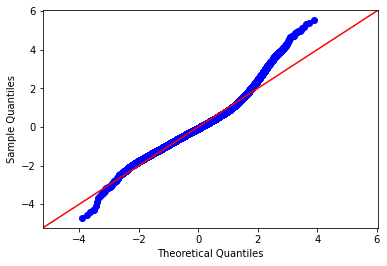

In [88]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [89]:
summary = model.summary()
p_table = summary.tables[1]
p_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.585e+07,6.11e+06,-9.140,0.000,-6.78e+07,-4.39e+07
id,-2.479e-07,2.96e-07,-0.838,0.402,-8.28e-07,3.32e-07
bedrooms,-1.051e+04,1187.308,-8.854,0.000,-1.28e+04,-8184.985
bathrooms,2.429e+04,2047.505,11.862,0.000,2.03e+04,2.83e+04
sqft_living,57.7698,11.921,4.846,0.000,34.404,81.136
sqft_lot,0.2170,0.030,7.224,0.000,0.158,0.276
floors,3.439e+04,2247.789,15.300,0.000,3e+04,3.88e+04
waterfront,1.693e+05,1.61e+04,10.500,0.000,1.38e+05,2.01e+05
view,3.446e+04,1405.172,24.524,0.000,3.17e+04,3.72e+04
condition,2.807e+04,1443.402,19.445,0.000,2.52e+04,3.09e+04


In [90]:
no_outliers.drop(['sqft_living15','sqft_lot15','yr_renovated','zipcode','sqft_above','sqft_basement','id','lat','long','year','month'], axis=1,inplace=True)

In [91]:
outcome='price'
new_x_cols=[col for col in no_outliers.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     3014.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:22   Log-Likelihood:            -2.7561e+05
No. Observations:               20742   AIC:                         5.512e+05
Df Residuals:                   20731   BIC:                         5.513e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.795e+06   8.92e+04     53.734      0.000    4.62e+06    4.97e+06
bedrooms    -1.515e+04   1396.177    -10.854      0.000   -1.79e+04   -1.24e+04
bathrooms    2.956e+04   2353.402     12.560      0.000    2.49e+04    3.42e+04
sqft_living    91.8543      2.365     38.842      0.000      87.219      96.490
sqft_lot       -0.0208      0.025     -0.822      0.411      -0.070       0.029
floors        3.97e+04   2330.277     17.037      0.000    3.51e+04    4.43e+04
waterfront   1.277e+05    1.9e+04      6.716      0.000    9.04e+04    1.65e+05
view         3.048e+04   1611.752     18.913      0.000    2.73e+04    3.36e+04
condition    1.824e+04   1663.088     10.970      0.000     1.5e+04    2.15e+04
grade        1.055e+05   1488.004     70.910      0.000    1.03e+05    1.08e+05
yr_built    -2753.2485     46.161    -59.644      0.000   -2843.729   -2662.768
==============================================================================
Omnibus:                     1272.564   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2153.991
Skew:                           0.484   Prob(JB):                         0.00
Kurtosis:                       4.247   Cond. No.                     3.84e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared has decreased to .593, but this decrease was expected because we removed quite a few variables. Even variables that are statistically insignicant tend to increase R-squared.

Our data is barely skewed at all by now, with a skew coefficient of .484 (slightly to the right). This is acceptable.

In our newest model, sqft_lot has become statistically insignificant (p-value: .411), but all other variables have a .000 p-value.

In [92]:
no_outliers.drop(['sqft_lot'], axis=1,inplace=True)

In [93]:
outcome='price'
new_x_cols=[col for col in no_outliers.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=no_outliers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     3349.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:22   Log-Likelihood:            -2.7561e+05
No. Observations:               20742   AIC:                         5.512e+05
Df Residuals:                   20732   BIC:                         5.513e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.798e+06   8.92e+04     53.791      0.000    4.62e+06    4.97e+06
bedrooms    -1.506e+04   1391.883    -10.823      0.000   -1.78e+04   -1.23e+04
bathrooms    2.963e+04   2351.533     12.602      0.000     2.5e+04    3.42e+04
sqft_living    91.5444      2.335     39.213      0.000      86.969      96.120
floors       3.982e+04   2325.652     17.123      0.000    3.53e+04    4.44e+04
waterfront   1.275e+05    1.9e+04      6.707      0.000    9.02e+04    1.65e+05
view         3.044e+04   1610.865     18.896      0.000    2.73e+04    3.36e+04
condition    1.824e+04   1663.075     10.970      0.000     1.5e+04    2.15e+04
grade        1.055e+05   1487.574     70.950      0.000    1.03e+05    1.08e+05
yr_built    -2754.7438     46.125    -59.723      0.000   -2845.153   -2664.335
==============================================================================
Omnibus:                     1273.434   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2155.775
Skew:                           0.485   Prob(JB):                         0.00
Kurtosis:                       4.247   Cond. No.                     2.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, all variables have a .000 p-value and appear to be statistically significant.

In [94]:
#Running a test to see a prediction for a sample house value.
4798000-2754*1970+91.544*2000-15060*2+29630*2+39820*2+127500+0+18240*3+105500*8

690708.0

This is about what we had expected for a house with those characteristics. Still, there is work to do. Next, we will make dummy variables for the categorical variables and try to reduce our condition number, which seems to indicate multicollinearlity.

In [95]:
bins=[0.5,2.50,7.75]
bins_bath=pd.cut(no_outliers['bathrooms'], bins)
bins_bath=bins_bath.cat.as_ordered()
bins_bath.head()

0     (0.5, 2.5]
1     (0.5, 2.5]
2     (0.5, 2.5]
3    (2.5, 7.75]
4     (0.5, 2.5]
Name: bathrooms, dtype: category
Categories (2, interval[float64]): [(0.5, 2.5] < (2.5, 7.75]]

In [96]:
no_outliers.bathrooms=bins_bath
no_outliers.bathrooms=no_outliers.bathrooms.cat.codes
bath_dummies=pd.get_dummies(bins_bath, prefix='bath')
df2=pd.concat([no_outliers,bath_dummies], axis=1)

In [97]:
df2.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,"bath_(0.5, 2.5]","bath_(2.5, 7.75]"
0,221900.0,3,0,1180,1.0,0.0,0.0,3,7,1955,1,0
1,538000.0,3,0,2570,2.0,0.0,0.0,3,7,1951,1,0
2,180000.0,2,0,770,1.0,0.0,0.0,3,6,1933,1,0
3,604000.0,4,1,1960,1.0,0.0,0.0,5,7,1965,0,1
4,510000.0,3,0,1680,1.0,0.0,0.0,3,8,1987,1,0


In [98]:
df2.drop(['bathrooms'], axis=1,inplace=True)

In [99]:
df2.head()

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,"bath_(0.5, 2.5]","bath_(2.5, 7.75]"
0,221900.0,3,1180,1.0,0.0,0.0,3,7,1955,1,0
1,538000.0,3,2570,2.0,0.0,0.0,3,7,1951,1,0
2,180000.0,2,770,1.0,0.0,0.0,3,6,1933,1,0
3,604000.0,4,1960,1.0,0.0,0.0,5,7,1965,0,1
4,510000.0,3,1680,1.0,0.0,0.0,3,8,1987,1,0


In [100]:
bedrooms_dummies = pd.get_dummies(no_outliers['bedrooms'], prefix='bedr', drop_first=True)
condition_dummies = pd.get_dummies(no_outliers['condition'], prefix='cond', drop_first=True)

In [101]:
data = pd.concat([df2,bedrooms_dummies,condition_dummies], axis=1)

In [102]:
data

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,"bath_(0.5, 2.5]",...,bedr_7,bedr_8,bedr_9,bedr_10,bedr_11,bedr_33,cond_2,cond_3,cond_4,cond_5
0,221900.0,3,1180,1.0,0.0,0.0,3,7,1955,1,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2570,2.0,0.0,0.0,3,7,1951,1,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,2,770,1.0,0.0,0.0,3,6,1933,1,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,4,1960,1.0,0.0,0.0,5,7,1965,0,...,0,0,0,0,0,0,0,0,0,1
4,510000.0,3,1680,1.0,0.0,0.0,3,8,1987,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,1530,3.0,0.0,0.0,3,8,2009,1,...,0,0,0,0,0,0,0,1,0,0
21593,400000.0,4,2310,2.0,0.0,0.0,3,8,2014,1,...,0,0,0,0,0,0,0,1,0,0
21594,402101.0,2,1020,2.0,0.0,0.0,3,7,2009,1,...,0,0,0,0,0,0,0,1,0,0
21595,400000.0,3,1600,2.0,0.0,0.0,3,8,2004,1,...,0,0,0,0,0,0,0,1,0,0


In [103]:
data.columns=data.columns.map(lambda x: x.replace('.','_').replace(',','_').replace('[','').replace(']','').replace('(','').replace(')',''))

In [104]:
data.head()

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,bath_0_5_ 2_5,...,bedr_7,bedr_8,bedr_9,bedr_10,bedr_11,bedr_33,cond_2,cond_3,cond_4,cond_5
0,221900.0,3,1180,1.0,0.0,0.0,3,7,1955,1,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2570,2.0,0.0,0.0,3,7,1951,1,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,2,770,1.0,0.0,0.0,3,6,1933,1,...,0,0,0,0,0,0,0,1,0,0
3,604000.0,4,1960,1.0,0.0,0.0,5,7,1965,0,...,0,0,0,0,0,0,0,0,0,1
4,510000.0,3,1680,1.0,0.0,0.0,3,8,1987,1,...,0,0,0,0,0,0,0,1,0,0


In [105]:
data.rename(columns={'bath_0_5_ 2_5': 'bath_low'},inplace=True)
data.rename(columns={'bath_2_5_ 7_75': 'bath_high'},inplace=True)

In [106]:
outcome='price'
new_x_cols=[col for col in data.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     1322.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:22   Log-Likelihood:            -2.7556e+05
No. Observations:               20742   AIC:                         5.512e+05
Df Residuals:                   20718   BIC:                         5.513e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.172e+06   1.11e+05     37.531      0.000    3.95e+06    4.39e+06
bedrooms     2896.7606   3520.489      0.823      0.411   -4003.675    9797.196
sqft_living    96.8230      2.239     43.247      0.000      92.435     101.211
floors       4.391e+04   2267.264     19.365      0.000    3.95e+04    4.84e+04
waterfront   1.274e+05    1.9e+04      6.714      0.000    9.02e+04    1.65e+05
view         3.013e+04   1608.395     18.732      0.000     2.7e+04    3.33e+04
condition     1.53e+05   8405.194     18.203      0.000    1.37e+05    1.69e+05
grade        1.068e+05   1496.230     71.371      0.000    1.04e+05     1.1e+05
yr_built    -2544.4779     44.347    -57.376      0.000   -2631.402   -2457.554
bath_low     9.175e+04   7.13e+04      1.287      0.198    -4.8e+04    2.31e+05
bath_high    1.332e+05   7.13e+04      1.866      0.062   -6698.477    2.73e+05
bedr_2       -1.07e+04   1.06e+04     -1.014      0.311   -3.14e+04    9988.260
bedr_3      -4.503e+04   1.15e+04     -3.917      0.000   -6.76e+04   -2.25e+04
bedr_4       -5.78e+04   1.36e+04     -4.254      0.000   -8.44e+04   -3.12e+04
bedr_5      -6.761e+04   1.65e+04     -4.107      0.000   -9.99e+04   -3.53e+04
bedr_6      -8.733e+04   2.09e+04     -4.171      0.000   -1.28e+05   -4.63e+04
bedr_7      -1.318e+05   3.29e+04     -4.002      0.000   -1.96e+05   -6.73e+04
bedr_8      -1.008e+05   5.22e+04     -1.929      0.054   -2.03e+05    1636.568
bedr_9      -1.033e+05   7.37e+04     -1.402      0.161   -2.48e+05    4.11e+04
bedr_10      1.681e+04   8.36e+04      0.201      0.841   -1.47e+05    1.81e+05
bedr_11      -2.53e+05   1.37e+05     -1.853      0.064   -5.21e+05    1.46e+04
bedr_33       4.73e+04   5.67e+04      0.835      0.404   -6.38e+04    1.58e+05
cond_2      -1.532e+05   2.23e+04     -6.870      0.000   -1.97e+05   -1.09e+05
cond_3      -2.681e+05   1.35e+04    -19.917      0.000   -2.94e+05   -2.42e+05
cond_4      -4.093e+05   1.12e+04    -36.532      0.000   -4.31e+05   -3.87e+05
cond_5      -5.254e+05   1.47e+04    -35.856      0.000   -5.54e+05   -4.97e+05
==============================================================================
Omnibus:                     1272.152   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2142.503
Skew:                           0.486   Prob(JB):                         0.00
Kurtosis:                       4.239   Cond. No.                     2.01e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.22e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [107]:
data.describe()

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,bath_low,...,bedr_7,bedr_8,bedr_9,bedr_10,bedr_11,bedr_33,cond_2,cond_3,cond_4,cond_5
count,2.074200e+04,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,...,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000,20742.000000
mean,4.871982e+05,3.340999,1997.125108,1.480233,0.002989,0.184167,3.406663,7.559396,1970.867949,0.846929,...,0.001543,0.000434,0.000193,0.000145,0.000048,0.000048,0.008148,0.649552,0.264391,0.076560
std,2.236077e+05,0.912421,797.480005,0.536993,0.054592,0.666459,0.647165,1.062901,29.202482,0.360065,...,0.039249,0.020826,0.013886,0.012026,0.006943,0.006943,0.089898,0.477122,0.441019,0.265898
min,7.800000e+04,1.000000,370.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.170000e+05,3.000000,1400.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.400000e+05,3.000000,1870.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1974.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.125000e+05,4.000000,2460.000000,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.260000e+06,33.000000,7480.000000,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
bins=[1.00,3.00,33]
bins_bedrooms=pd.cut(data['bedrooms'], bins)
bins_bedrooms=bins_bedrooms.cat.as_ordered()
bins_bedrooms.head()

0     (1.0, 3.0]
1     (1.0, 3.0]
2     (1.0, 3.0]
3    (3.0, 33.0]
4     (1.0, 3.0]
Name: bedrooms, dtype: category
Categories (2, interval[float64]): [(1.0, 3.0] < (3.0, 33.0]]

In [109]:
data.bedrooms=bins_bedrooms
data.bedrooms=data.bedrooms.cat.codes
bedr_dummies=pd.get_dummies(bins_bedrooms, prefix='bedr')

In [110]:
df3=pd.concat([data,bedr_dummies], axis=1)
df3.drop(['bedrooms'], axis=1,inplace=True)

In [111]:
df3.columns=df3.columns.map(lambda x: x.replace('.','_').replace(',','_').replace('[','').replace(']','').replace('(','').replace(')',''))

In [112]:
df3.rename(columns={'bedr_3_0_ 33_0': 'bedr_high'},inplace=True)
df3.rename(columns={'bedr_1_0_ 3_0': 'bedr_low'},inplace=True)

In [113]:
df3.drop(['bedr_2','bedr_3','bedr_4','bedr_5','bedr_6','bedr_7','bedr_8','bedr_9',
               'bedr_10','bedr_11','bedr_33'],axis=1,inplace=True)

In [114]:
outcome='price'
new_x_cols=[col for col in df3.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2153.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:23   Log-Likelihood:            -2.7561e+05
No. Observations:               20742   AIC:                         5.513e+05
Df Residuals:                   20727   BIC:                         5.514e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.271e+06   1.11e+05     38.644      0.000    4.05e+06    4.49e+06
sqft_living    91.1778      2.159     42.241      0.000      86.947      95.409
floors       4.444e+04   2269.851     19.578      0.000       4e+04    4.89e+04
waterfront   1.314e+05    1.9e+04      6.909      0.000    9.41e+04    1.69e+05
view         3.072e+04   1611.139     19.069      0.000    2.76e+04    3.39e+04
condition    1.543e+05   8418.519     18.332      0.000    1.38e+05    1.71e+05
grade        1.078e+05   1483.316     72.683      0.000    1.05e+05    1.11e+05
yr_built    -2587.7475     43.983    -58.835      0.000   -2673.958   -2501.537
bath_low     8.109e+04   7.14e+04      1.135      0.256   -5.89e+04    2.21e+05
bath_high    1.224e+05   7.15e+04      1.711      0.087   -1.78e+04    2.63e+05
cond_2      -1.574e+05   2.24e+04     -7.041      0.000   -2.01e+05   -1.14e+05
cond_3      -2.756e+05   1.35e+04    -20.475      0.000   -3.02e+05   -2.49e+05
cond_4      -4.196e+05   1.11e+04    -37.659      0.000   -4.41e+05   -3.98e+05
cond_5      -5.373e+05   1.46e+04    -36.864      0.000   -5.66e+05   -5.09e+05
bedr_low    -2.775e+04   1.04e+04     -2.667      0.008   -4.81e+04   -7353.037
bedr_high   -4.219e+04   1.07e+04     -3.956      0.000   -6.31e+04   -2.13e+04
==============================================================================
Omnibus:                     1257.556   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2091.172
Skew:                           0.485   Prob(JB):                         0.00
Kurtosis:                       4.216   Cond. No.                     1.42e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.51e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

It appears that bedr_high (all homes with more than 3 bedrooms fall into this category) has a negative impact on price. Let's see what happens when we remove this variable, as having both this and bedr_low in our model could cause problems.

In [115]:
df4=df3

In [116]:
#df4.drop(['bath_low'], axis=1,inplace=True)

In [117]:
outcome='price'
new_x_cols=[col for col in df4.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df4).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2153.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:23   Log-Likelihood:            -2.7561e+05
No. Observations:               20742   AIC:                         5.513e+05
Df Residuals:                   20727   BIC:                         5.514e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.271e+06   1.11e+05     38.644      0.000    4.05e+06    4.49e+06
sqft_living    91.1778      2.159     42.241      0.000      86.947      95.409
floors       4.444e+04   2269.851     19.578      0.000       4e+04    4.89e+04
waterfront   1.314e+05    1.9e+04      6.909      0.000    9.41e+04    1.69e+05
view         3.072e+04   1611.139     19.069      0.000    2.76e+04    3.39e+04
condition    1.543e+05   8418.519     18.332      0.000    1.38e+05    1.71e+05
grade        1.078e+05   1483.316     72.683      0.000    1.05e+05    1.11e+05
yr_built    -2587.7475     43.983    -58.835      0.000   -2673.958   -2501.537
bath_low     8.109e+04   7.14e+04      1.135      0.256   -5.89e+04    2.21e+05
bath_high    1.224e+05   7.15e+04      1.711      0.087   -1.78e+04    2.63e+05
cond_2      -1.574e+05   2.24e+04     -7.041      0.000   -2.01e+05   -1.14e+05
cond_3      -2.756e+05   1.35e+04    -20.475      0.000   -3.02e+05   -2.49e+05
cond_4      -4.196e+05   1.11e+04    -37.659      0.000   -4.41e+05   -3.98e+05
cond_5      -5.373e+05   1.46e+04    -36.864      0.000   -5.66e+05   -5.09e+05
bedr_low    -2.775e+04   1.04e+04     -2.667      0.008   -4.81e+04   -7353.037
bedr_high   -4.219e+04   1.07e+04     -3.956      0.000   -6.31e+04   -2.13e+04
==============================================================================
Omnibus:                     1257.556   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2091.172
Skew:                           0.485   Prob(JB):                         0.00
Kurtosis:                       4.216   Cond. No.                     1.42e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.51e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [118]:
df5=df4

In [119]:
#df5.drop(['bedr_high'], axis=1,inplace=True)

In [120]:
outcome='price'
new_x_cols=[col for col in df5.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df5).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2153.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:23   Log-Likelihood:            -2.7561e+05
No. Observations:               20742   AIC:                         5.513e+05
Df Residuals:                   20727   BIC:                         5.514e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.271e+06   1.11e+05     38.644      0.000    4.05e+06    4.49e+06
sqft_living    91.1778      2.159     42.241      0.000      86.947      95.409
floors       4.444e+04   2269.851     19.578      0.000       4e+04    4.89e+04
waterfront   1.314e+05    1.9e+04      6.909      0.000    9.41e+04    1.69e+05
view         3.072e+04   1611.139     19.069      0.000    2.76e+04    3.39e+04
condition    1.543e+05   8418.519     18.332      0.000    1.38e+05    1.71e+05
grade        1.078e+05   1483.316     72.683      0.000    1.05e+05    1.11e+05
yr_built    -2587.7475     43.983    -58.835      0.000   -2673.958   -2501.537
bath_low     8.109e+04   7.14e+04      1.135      0.256   -5.89e+04    2.21e+05
bath_high    1.224e+05   7.15e+04      1.711      0.087   -1.78e+04    2.63e+05
cond_2      -1.574e+05   2.24e+04     -7.041      0.000   -2.01e+05   -1.14e+05
cond_3      -2.756e+05   1.35e+04    -20.475      0.000   -3.02e+05   -2.49e+05
cond_4      -4.196e+05   1.11e+04    -37.659      0.000   -4.41e+05   -3.98e+05
cond_5      -5.373e+05   1.46e+04    -36.864      0.000   -5.66e+05   -5.09e+05
bedr_low    -2.775e+04   1.04e+04     -2.667      0.008   -4.81e+04   -7353.037
bedr_high   -4.219e+04   1.07e+04     -3.956      0.000   -6.31e+04   -2.13e+04
==============================================================================
Omnibus:                     1257.556   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2091.172
Skew:                           0.485   Prob(JB):                         0.00
Kurtosis:                       4.216   Cond. No.                     1.42e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.51e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

It appears that surprisingly, bedr_low (pertains to houses with between 1 and 3 bedrooms) has a positive impact on price. While this is statistically significant, the impact is not as large in magnitude as most other variables.

In [121]:
df6=df5
df6.drop(['cond_2','cond_3','cond_4'], axis=1,inplace=True)
outcome='price'
new_x_cols=[col for col in df6.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df6).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2512.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:23   Log-Likelihood:            -2.7561e+05
No. Observations:               20742   AIC:                         5.513e+05
Df Residuals:                   20729   BIC:                         5.514e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.401e+06    1.1e+05     39.958      0.000    4.19e+06    4.62e+06
sqft_living    91.1175      2.158     42.219      0.000      86.887      95.348
floors       4.474e+04   2265.932     19.744      0.000    4.03e+04    4.92e+04
waterfront   1.314e+05    1.9e+04      6.910      0.000    9.41e+04    1.69e+05
view         3.073e+04   1611.207     19.076      0.000    2.76e+04    3.39e+04
condition    1.208e+04   2292.868      5.269      0.000    7586.359    1.66e+04
grade         1.08e+05   1480.948     72.909      0.000    1.05e+05    1.11e+05
yr_built    -2578.1655     43.707    -58.988      0.000   -2663.834   -2492.497
bath_low     8.017e+04   7.14e+04      1.122      0.262   -5.99e+04     2.2e+05
bath_high    1.215e+05   7.15e+04      1.699      0.089   -1.87e+04    2.62e+05
cond_5       2.389e+04   5320.987      4.490      0.000    1.35e+04    3.43e+04
bedr_low    -2.712e+04   1.04e+04     -2.609      0.009   -4.75e+04   -6743.570
bedr_high   -4.161e+04   1.07e+04     -3.904      0.000   -6.25e+04   -2.07e+04
==============================================================================
Omnibus:                     1249.258   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2072.590
Skew:                           0.483   Prob(JB):                         0.00
Kurtosis:                       4.210   Cond. No.                     3.92e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

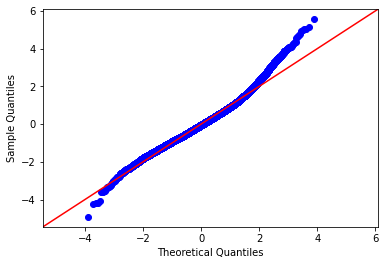

In [122]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [123]:
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

#make X,y to put in the train-test split
y=df6.price
X=df6.drop('price', axis=1)

In [124]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [125]:
print(len(X_train), len(X_test))

16593 4149


In [126]:
linreg=LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train=linreg.predict(X_train)
y_hat_test=linreg.predict(X_test)

In [127]:
y_hat_test

array([638368.87997441,  97635.78344464, 487580.18776716, ...,
       957727.45049158, 518098.98994155, 347669.06748779])

In [128]:
y_test

4863     600000.0
465       80000.0
16421    539000.0
9357     325000.0
2857     322000.0
           ...   
11678    412000.0
10316    554500.0
8135     875000.0
5342     335000.0
15773    455000.0
Name: price, Length: 4149, dtype: float64

In [129]:
train_mse=mean_squared_error(y_train, y_hat_train)
test_mse=mean_squared_error(y_test, y_hat_test)

print('Train Mean Squared Error {}'.format(train_mse))
print('Test Mean Squared Error {}'.format(test_mse))
print('Root Train Mean Squared Error {}'.format(train_mse**0.5))
print('Root Test Mean Squared Error {}'.format(test_mse**0.5))

Train Mean Squared Error 20530359934.438503
Test Mean Squared Error 19790660379.739704
Root Train Mean Squared Error 143284.19289802524
Root Test Mean Squared Error 140679.28198473188


After working on outliers, data cleaning, dummy valiables, and initial iterations of our model, we made a new csv that is easier to work with.

In [130]:
#outcome='price'
#x_cols=df.drop('price',axis=1)

In [131]:
#predictors = '+'.join(x_cols)
#formula = outcome + "~" + predictors
#model = ols(formula=formula, data=df).fit()
#model.summary()

In [132]:
#remove the variables with p-values higher than 0.05
#summary=model.summary()
#p_table = summary.tables[1]
#p_table = pd.DataFrame(p_table.data)
#p_table.columns = p_table.iloc[0]
#p_table = p_table.drop(0)
#p_table = p_table.set_index(p_table.columns[0])
#p_table['P>|t|'] = p_table['P>|t|'].astype(float)
#x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
#x_cols.remove('Intercept')
#print(len(p_table), len(x_cols))
#print(x_cols[:5])
#p_table.head()

In [133]:
# Refit model with subset features
#predictors = '+'.join(x_cols)
#formula = outcome + "~" + predictors
#model = ols(formula=formula, data=df).fit()
#model.summary()

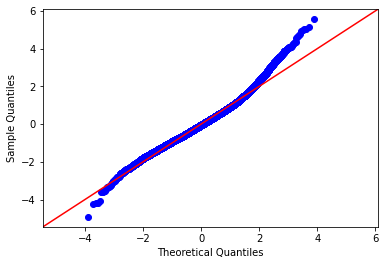

In [134]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [135]:
#from sklearn.metrics import mean_squared_error 
#from sklearn.linear_model import LinearRegression

#make X,y to put in the train-test split
#y=df.price
#X=df.drop('price', axis=1)

In [136]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [137]:
print(len(X_train), len(X_test))

16593 4149


In [138]:
linreg=LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train=linreg.predict(X_train)
y_hat_test=linreg.predict(X_test)

In [139]:
y_hat_test

array([638368.87997441,  97635.78344464, 487580.18776716, ...,
       957727.45049158, 518098.98994155, 347669.06748779])

In [140]:
y_test

4863     600000.0
465       80000.0
16421    539000.0
9357     325000.0
2857     322000.0
           ...   
11678    412000.0
10316    554500.0
8135     875000.0
5342     335000.0
15773    455000.0
Name: price, Length: 4149, dtype: float64

In [141]:
outcome='price'
new_x_cols=[col for col in df6.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df6).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2512.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:24   Log-Likelihood:            -2.7561e+05
No. Observations:               20742   AIC:                         5.513e+05
Df Residuals:                   20729   BIC:                         5.514e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.401e+06    1.1e+05     39.958      0.000    4.19e+06    4.62e+06
sqft_living    91.1175      2.158     42.219      0.000      86.887      95.348
floors       4.474e+04   2265.932     19.744      0.000    4.03e+04    4.92e+04
waterfront   1.314e+05    1.9e+04      6.910      0.000    9.41e+04    1.69e+05
view         3.073e+04   1611.207     19.076      0.000    2.76e+04    3.39e+04
condition    1.208e+04   2292.868      5.269      0.000    7586.359    1.66e+04
grade         1.08e+05   1480.948     72.909      0.000    1.05e+05    1.11e+05
yr_built    -2578.1655     43.707    -58.988      0.000   -2663.834   -2492.497
bath_low     8.017e+04   7.14e+04      1.122      0.262   -5.99e+04     2.2e+05
bath_high    1.215e+05   7.15e+04      1.699      0.089   -1.87e+04    2.62e+05
cond_5       2.389e+04   5320.987      4.490      0.000    1.35e+04    3.43e+04
bedr_low    -2.712e+04   1.04e+04     -2.609      0.009   -4.75e+04   -6743.570
bedr_high   -4.161e+04   1.07e+04     -3.904      0.000   -6.25e+04   -2.07e+04
==============================================================================
Omnibus:                     1249.258   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2072.590
Skew:                           0.483   Prob(JB):                         0.00
Kurtosis:                       4.210   Cond. No.                     3.92e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [142]:
#Check for mean squared error
train_mse=mean_squared_error(y_train, y_hat_train)
test_mse=mean_squared_error(y_test, y_hat_test)

print('Train Mean Squared Error {}'.format(train_mse))
print('Test Mean Squared Error {}'.format(test_mse))
print('Root Train Mean Squared Error {}'.format(train_mse**0.5))
print('Root Test Mean Squared Error {}'.format(test_mse**0.5))

Train Mean Squared Error 20530359934.438503
Test Mean Squared Error 19790660379.739704
Root Train Mean Squared Error 143284.19289802524
Root Test Mean Squared Error 140679.28198473188


(1) On the newest model, R-squared is still lower than we would like it to be, but it still indicates that our model explains 59.6% of the variation of our dependent variable (price) can be explained by variation in our independent variables. (2) Root Mean Squared Error is high, about 140,000. (3) QQ plot still has a slight head and tail (outliers) but appears to be satisfactory.

Try cross-validation? No clear limit on how many times we should do train-test.

In [143]:
df7=df6

In [144]:
#Getting rid of condition because we already have a
#dummy variable that indicates if a home was given a condition of 5.
df7.drop(['condition'], axis=1,inplace=True)

In [145]:
outcome='price'
new_x_cols=[col for col in df7.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df7).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2734.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:24   Log-Likelihood:            -2.7563e+05
No. Observations:               20742   AIC:                         5.513e+05
Df Residuals:                   20730   BIC:                         5.514e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.518e+06   1.08e+05     41.842      0.000    4.31e+06    4.73e+06
sqft_living    91.5555      2.158     42.426      0.000      87.326      95.785
floors       4.287e+04   2239.471     19.143      0.000    3.85e+04    4.73e+04
waterfront   1.321e+05    1.9e+04      6.943      0.000    9.48e+04    1.69e+05
view          3.08e+04   1612.198     19.105      0.000    2.76e+04     3.4e+04
grade         1.08e+05   1481.902     72.855      0.000    1.05e+05    1.11e+05
yr_built    -2617.9235     43.078    -60.771      0.000   -2702.360   -2533.487
bath_low     8.099e+04   7.15e+04      1.133      0.257   -5.91e+04    2.21e+05
bath_high    1.218e+05   7.16e+04      1.702      0.089   -1.85e+04    2.62e+05
cond_5       4.324e+04   3853.573     11.220      0.000    3.57e+04    5.08e+04
bedr_low    -2.448e+04   1.04e+04     -2.356      0.018   -4.49e+04   -4114.971
bedr_high   -3.873e+04   1.07e+04     -3.636      0.000   -5.96e+04   -1.78e+04
==============================================================================
Omnibus:                     1253.275   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2078.323
Skew:                           0.485   Prob(JB):                         0.00
Kurtosis:                       4.210   Cond. No.                     3.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

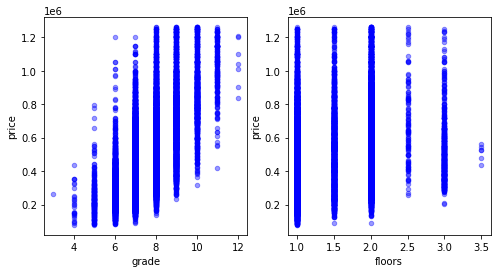

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for xcol, ax in zip(['grade','floors'], axes):
    df7.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

As grade and floors are categorical, we will want to split these up into dummy variables as we did for bedrooms and bathrooms.

Grade: Overall grade given to the housing unit, based on King County grading system.

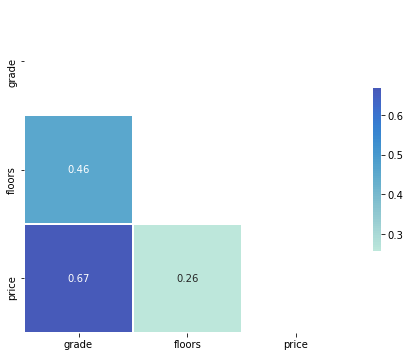

In [147]:
corr = df_data[['grade','floors','price']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

Judging from our model and the correlations, it certainly seems that a higher grade is a good thing. Let's observe this variable further, along with floors.

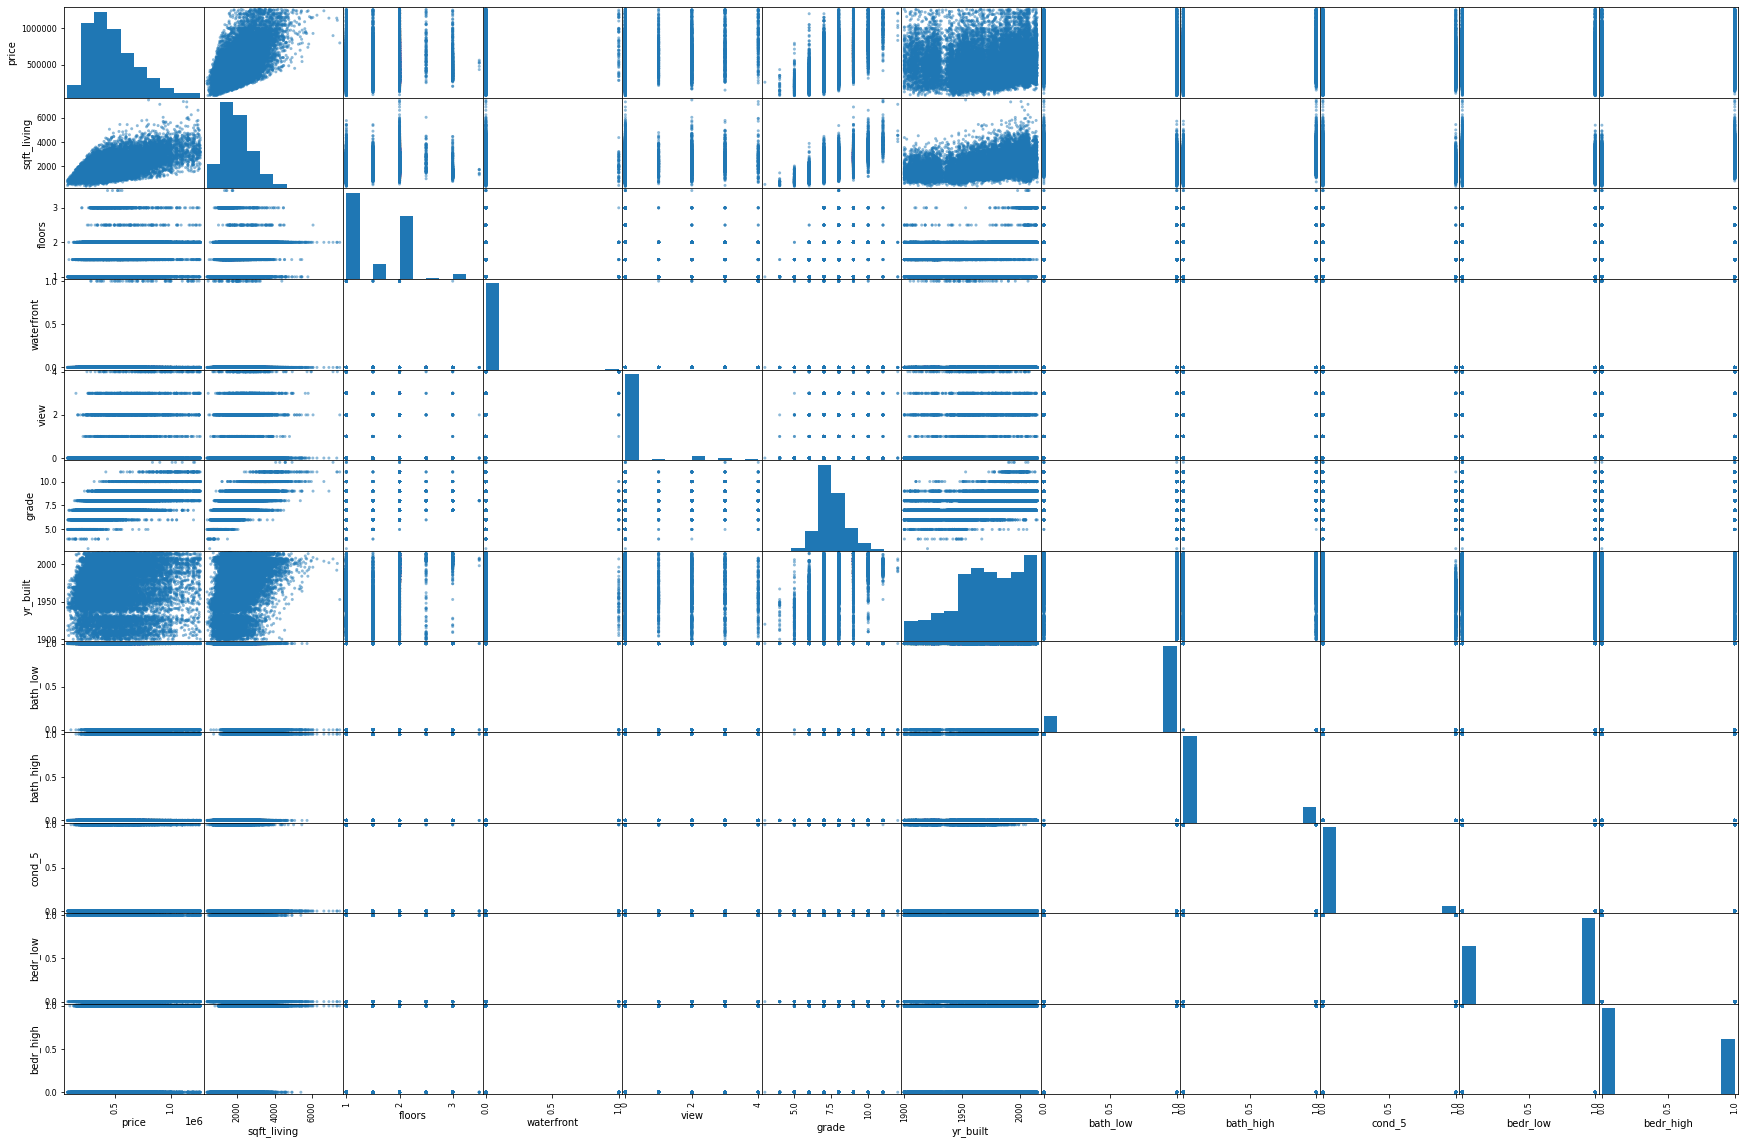

In [148]:
pd.plotting.scatter_matrix(df7, alpha=0.5, figsize=(30,20))
plt.show()

In [149]:
bins=[3,7,12]
bins_grade=pd.cut(df7['grade'], bins)
bins_grade=bins_grade.cat.as_ordered()
bins_grade.head()

0     (3, 7]
1     (3, 7]
2     (3, 7]
3     (3, 7]
4    (7, 12]
Name: grade, dtype: category
Categories (2, interval[int64]): [(3, 7] < (7, 12]]

In [150]:
df7.grade=bins_grade
df7.grade=df7.grade.cat.codes
grade_dummies=pd.get_dummies(bins_grade, prefix='grade')
df8=pd.concat([df7,grade_dummies], axis=1)

In [151]:
#df8.drop(['grade'], axis=1,inplace=True)

In [152]:
df8.rename(columns={'grade_(3, 7]': 'grade_low'},inplace=True)
df8.rename(columns={'grade_(7, 12]': 'grade_high'},inplace=True)
df8.head()

,price,sqft_living,floors,waterfront,view,grade,yr_built,bath_low,bath_high,cond_5,bedr_low,bedr_high,grade_low,grade_high
0,221900.0,1180,1.0,0.0,0.0,0,1955,1,0,0,1,0,1,0
1,538000.0,2570,2.0,0.0,0.0,0,1951,1,0,0,1,0,1,0
2,180000.0,770,1.0,0.0,0.0,0,1933,1,0,0,1,0,1,0
3,604000.0,1960,1.0,0.0,0.0,0,1965,0,1,1,0,1,1,0
4,510000.0,1680,1.0,0.0,0.0,1,1987,1,0,0,1,0,0,1


In [153]:
outcome='price'
new_x_cols=[col for col in df8.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df8).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     1992.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:49   Log-Likelihood:            -2.7697e+05
No. Observations:               20742   AIC:                         5.540e+05
Df Residuals:                   20729   BIC:                         5.541e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.751e+06   1.19e+05     31.609      0.000    3.52e+06    3.98e+06
sqft_living   145.9006      2.038     71.605      0.000     141.907     149.894
floors       4.954e+04   2407.243     20.580      0.000    4.48e+04    5.43e+04
waterfront   1.088e+05   2.03e+04      5.361      0.000     6.9e+04    1.49e+05
view         3.323e+04   1721.686     19.304      0.000    2.99e+04    3.66e+04
grade       -5.519e+05   8.88e+04     -6.215      0.000   -7.26e+05   -3.78e+05
yr_built    -2260.6157     45.435    -49.755      0.000   -2349.671   -2171.560
bath_low     1.371e+05   7.63e+04      1.797      0.072   -1.24e+04    2.87e+05
bath_high    1.778e+05   7.63e+04      2.328      0.020    2.81e+04    3.27e+05
cond_5       3.705e+04   4111.100      9.011      0.000     2.9e+04    4.51e+04
bedr_low     1.435e+04   1.11e+04      1.292      0.197   -7425.325    3.61e+04
bedr_high   -1.355e+04   1.14e+04     -1.189      0.234   -3.59e+04    8780.715
grade_low    6.116e+05   6.76e+04      9.044      0.000    4.79e+05    7.44e+05
grade_high   1.294e+06   3.97e+04     32.593      0.000    1.22e+06    1.37e+06
==============================================================================
Omnibus:                      976.442   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1398.229
Skew:                           0.444   Prob(JB):                    2.39e-304
Kurtosis:                       3.910   Cond. No.                     1.94e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.53e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [154]:
df8.drop(columns=['grade_low'],inplace=True)

In [155]:
outcome='price'
new_x_cols=[col for col in df8.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df8).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     1992.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:50   Log-Likelihood:            -2.7697e+05
No. Observations:               20742   AIC:                         5.540e+05
Df Residuals:                   20729   BIC:                         5.541e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.363e+06   1.16e+05     37.710      0.000    4.14e+06    4.59e+06
sqft_living   145.9006      2.038     71.605      0.000     141.907     149.894
floors       4.954e+04   2407.243     20.580      0.000    4.48e+04    5.43e+04
waterfront   1.088e+05   2.03e+04      5.361      0.000     6.9e+04    1.49e+05
view         3.323e+04   1721.686     19.304      0.000    2.99e+04    3.66e+04
grade        5.971e+04   1.53e+05      0.391      0.696    -2.4e+05    3.59e+05
yr_built    -2260.6157     45.435    -49.755      0.000   -2349.671   -2171.560
bath_low     1.371e+05   7.63e+04      1.797      0.072   -1.24e+04    2.87e+05
bath_high    1.778e+05   7.63e+04      2.328      0.020    2.81e+04    3.27e+05
cond_5       3.705e+04   4111.100      9.011      0.000     2.9e+04    4.51e+04
bedr_low     1.435e+04   1.11e+04      1.292      0.197   -7425.325    3.61e+04
bedr_high   -1.355e+04   1.14e+04     -1.189      0.234   -3.59e+04    8780.715
grade_high   7.059e+04   1.53e+05      0.462      0.644   -2.29e+05     3.7e+05
==============================================================================
Omnibus:                      976.442   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1398.229
Skew:                           0.444   Prob(JB):                    2.39e-304
Kurtosis:                       3.910   Cond. No.                     5.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [156]:
view_dummies=pd.get_dummies(df8.view, prefix='view',drop_first=True)
df9=pd.concat([df8,view_dummies], axis=1)

In [157]:
df9.drop(columns=['view'],inplace=True)

In [158]:
df9.head()

,price,sqft_living,floors,waterfront,grade,yr_built,bath_low,bath_high,cond_5,bedr_low,bedr_high,grade_high,view_1.0,view_2.0,view_3.0,view_4.0
0,221900.0,1180,1.0,0.0,0,1955,1,0,0,1,0,0,0,0,0,0
1,538000.0,2570,2.0,0.0,0,1951,1,0,0,1,0,0,0,0,0,0
2,180000.0,770,1.0,0.0,0,1933,1,0,0,1,0,0,0,0,0,0
3,604000.0,1960,1.0,0.0,0,1965,0,1,1,0,1,0,0,0,0,0
4,510000.0,1680,1.0,0.0,1,1987,1,0,0,1,0,1,0,0,0,0


In [159]:
df9.columns=df9.columns.map(lambda x: x.replace('.','_'))

In [160]:
outcome='price'
new_x_cols=[col for col in df9.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df9).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     1601.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:50   Log-Likelihood:            -2.7694e+05
No. Observations:               20742   AIC:                         5.539e+05
Df Residuals:                   20726   BIC:                         5.540e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.347e+06   1.16e+05     37.601      0.000    4.12e+06    4.57e+06
sqft_living   145.6276      2.036     71.536      0.000     141.637     149.618
floors       4.979e+04   2405.282     20.700      0.000    4.51e+04    5.45e+04
waterfront   7.503e+04    2.2e+04      3.418      0.001     3.2e+04    1.18e+05
grade        5.905e+04   1.53e+05      0.387      0.699    -2.4e+05    3.58e+05
yr_built    -2252.8768     45.424    -49.597      0.000   -2341.911   -2163.843
bath_low     1.367e+05   7.62e+04      1.794      0.073   -1.26e+04    2.86e+05
bath_high    1.775e+05   7.63e+04      2.328      0.020    2.81e+04    3.27e+05
cond_5       3.709e+04   4106.580      9.032      0.000     2.9e+04    4.51e+04
bedr_low     1.476e+04   1.11e+04      1.330      0.183   -6986.820    3.65e+04
bedr_high   -1.307e+04   1.14e+04     -1.149      0.251   -3.54e+04    9232.974
grade_high   7.101e+04   1.53e+05      0.465      0.642   -2.28e+05     3.7e+05
view_1_0      8.25e+04   9120.413      9.046      0.000    6.46e+04       1e+05
view_2_0     5.739e+04   5461.447     10.509      0.000    4.67e+04    6.81e+04
view_3_0      8.06e+04   7985.876     10.093      0.000    6.49e+04    9.63e+04
view_4_0     1.791e+05   1.31e+04     13.667      0.000    1.53e+05    2.05e+05
==============================================================================
Omnibus:                      978.780   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1405.493
Skew:                           0.444   Prob(JB):                    6.32e-306
Kurtosis:                       3.915   Cond. No.                     5.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [161]:
df10=df9

In [162]:
df10.drop(columns=['view_1_0','view_2_0','view_3_0'],inplace=True)

In [163]:
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     1954.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:22:50   Log-Likelihood:            -2.7708e+05
No. Observations:               20742   AIC:                         5.542e+05
Df Residuals:                   20729   BIC:                         5.543e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     4.53e+06   1.16e+05     39.123      0.000     4.3e+06    4.76e+06
sqft_living   150.0526      2.030     73.917      0.000     146.074     154.032
floors       4.772e+04   2417.312     19.740      0.000     4.3e+04    5.25e+04
waterfront   9.513e+04    2.2e+04      4.316      0.000    5.19e+04    1.38e+05
grade        6.316e+04   1.54e+05      0.411      0.681   -2.38e+05    3.64e+05
yr_built    -2347.8346     45.329    -51.796      0.000   -2436.682   -2258.987
bath_low     1.405e+05   7.67e+04      1.833      0.067   -9737.298    2.91e+05
bath_high    1.841e+05   7.67e+04      2.398      0.016    3.36e+04    3.35e+05
cond_5       3.648e+04   4132.496      8.827      0.000    2.84e+04    4.46e+04
bedr_low     1.312e+04   1.12e+04      1.175      0.240   -8763.664     3.5e+04
bedr_high   -1.763e+04   1.14e+04     -1.540      0.124   -4.01e+04    4810.795
grade_high   7.125e+04   1.54e+05      0.464      0.643    -2.3e+05    3.72e+05
view_4_0      1.63e+05   1.31e+04     12.399      0.000    1.37e+05    1.89e+05
==============================================================================
Omnibus:                     1026.055   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1478.533
Skew:                           0.458   Prob(JB):                         0.00
Kurtosis:                       3.933   Cond. No.                     5.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
df10.drop(columns=['bath_low','bedr_high','grade'],inplace=True)
outcome='price'
new_x_cols=[col for col in df10.columns]
new_x_cols.remove('price')
predictors='+'.join(new_x_cols)
formula=outcome+'~'+predictors
model=ols(formula=formula,data=df10).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     2604.
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:26:38   Log-Likelihood:            -2.7708e+05
No. Observations:               20742   AIC:                         5.542e+05
Df Residuals:                   20732   BIC:                         5.543e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.659e+06   8.74e+04     53.317      0.000    4.49e+06    4.83e+06
sqft_living   149.5030      1.991     75.101      0.000     145.601     153.405
floors       4.772e+04   2417.465     19.738      0.000     4.3e+04    5.25e+04
waterfront   9.583e+04    2.2e+04      4.348      0.000    5.26e+04    1.39e+05
yr_built    -2349.9792     45.293    -51.884      0.000   -2438.757   -2261.201
bath_high    4.361e+04   3401.777     12.819      0.000    3.69e+04    5.03e+04
cond_5        3.63e+04   4129.793      8.791      0.000    2.82e+04    4.44e+04
bedr_low     2.992e+04   2558.897     11.693      0.000    2.49e+04    3.49e+04
grade_high   1.345e+05   2813.132     47.817      0.000    1.29e+05     1.4e+05
view_4_0     1.635e+05   1.31e+04     12.439      0.000    1.38e+05    1.89e+05
==============================================================================
Omnibus:                     1026.735   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1477.644
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                       3.931   Cond. No.                     2.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We are being warned of multicollinearity problems causing the condition number to be large. Let's investigate.

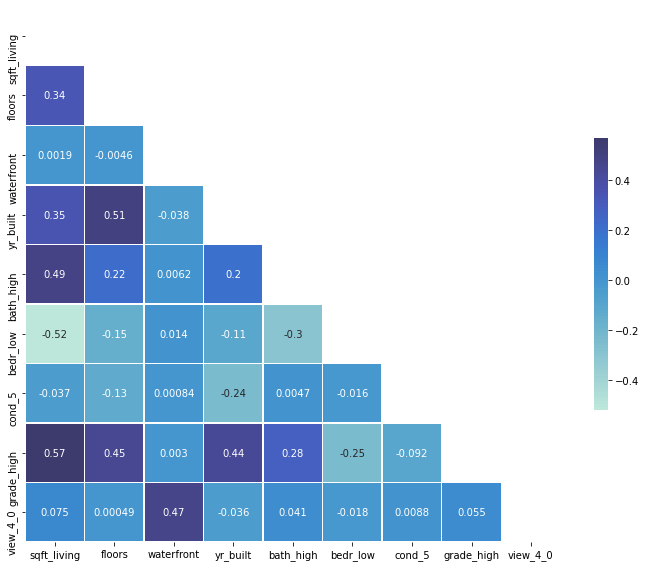

In [164]:
corr = df10[['sqft_living','floors','waterfront','yr_built','bath_high','bedr_low','cond_5','grade_high','view_4_0']].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, center=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

None of our features are highly collinear (>.75 correlation coefficient) with each other.

In [165]:
#sns.boxplot(x=df['price'])

In [166]:
#train_mse=mean_squared_error(y_train, y_hat_train)
#test_mse=mean_squared_error(y_test, y_hat_test)

#print('Train Mean Squared Error {}'.format(train_mse))
#print('Test Mean Squared Error {}'.format(test_mse))
#print('Root Train Mean Squared Error {}'.format(train_mse**0.5))
#print('Root Test Mean Squared Error {}'.format(test_mse**0.5))

In [167]:
#df_data.insert(2, "bathroom_dummy_new", bins_bath, True)